# **Convective State Analysis**

The goal is to analyze each convective state independently, thresholding based on the MLD in the Weddell Sea.

In [72]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice.")

import xarray as xr
import numpy as np
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLD Timeseries
Inspect annual and monthly mean MLD timeseries to develop a method for defining the convective states.

In [3]:
rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
var = 'mld'

pcs.dir_inspect('/home/bbuchovecky/storage/so_predict_derived/MLD_ENSEMBLE')

['mld_ens_global_annual_mean.nc',
 'mld_ens_global_monthly_anom.nc',
 'mld_ens_global_monthly_mean.nc',
 'mld_ens_so_annual_mean.nc',
 'mld_ens_so_monthly_anom.nc',
 'mld_ens_so_monthly_mean.nc']

In [7]:
def open_ctrl(var, timescale, metric, reg='so', form='ts', print_path=True):
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)
    
def open_ens(var, reg, timescale, metric, form='ts', print_path=True):
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)

mld_ts_annual_mean = open_ctrl('mld', 'annual', 'mean')
mld_ts_monthly_mean = open_ctrl('mld', 'monthly', 'mean')

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc
opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_monthly_mean.nc


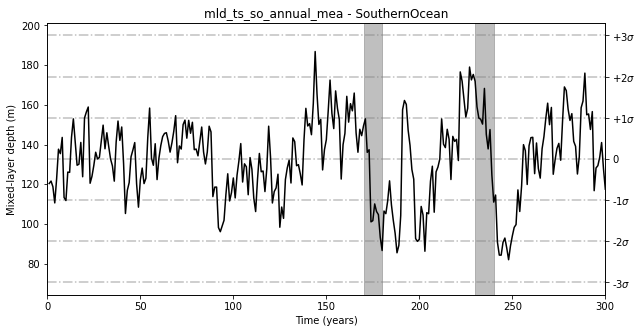

In [43]:
fig,ax = vis.stdev_plot(mld_ts_annual_mean, 'SouthernOcean')

ax.axvspan(170,180, color='gray', alpha=0.5)
ax.axvspan(230,240, color='gray', alpha=0.5)

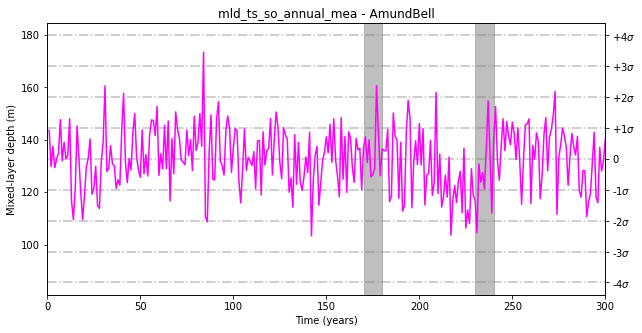

In [44]:
fig,ax = vis.stdev_plot(mld_ts_annual_mean, 'AmundBell')

# ax.axvspan(169,179,color='gray', alpha=0.5)
ax.axvspan(170,180,color='gray', alpha=0.5)
ax.axvspan(230,240, color='gray', alpha=0.5)

In [142]:
def open_ctrl(
    var, timescale, metric, reg='so', form='ts', print_path=True):
    
    rootdir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_'+form+'_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if print_path:
        print('opened - '+rootdir+subdir+filename)
    return xr.open_dataset(rootdir+subdir+filename)

def ctrl_grid_plot(
    var, ts=None, timescale='annual', metric='mean', sharey=True, ens_ticks=True, ens_spans=True, figsize=(12,6), bbox_to_anchor=(1,1.01)):
    
    if ts == None:
        ts = open_ctrl(var, timescale, metric, reg='so', form='ts', print_path=True)
    assert len(ts.data_vars) == 6, '\'annual_mean\' needs 6 data variables corresponding to each region in the Southern Ocean.'
    
    ## import dictionaries containing variable and region details
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    ens_runs = np.array([22,64,106,170,232,295])
    ens_runs_labels = np.array([22,64,106,170,232,295])
    duration = 10
    
    rows = 2
    cols = 3
    
    if sharey:
        fig,axes = plt.subplots(rows,cols, sharey=True, figsize=figsize)
    if not sharey:
        fig,axes = plt.subplots(rows,cols, figsize=figsize)
        
    if timescale == 'annual':
        time = np.arange(1, ts['year'].max().values+1)
        xlim = [1, ts['year'].max().values]
    if timescale == 'monthly':
        time = np.arange(1, ts['time'].size+1)
        xlim = [1, ts['time'].size]
        ens_runs = ens_runs*12
        duration = duration*12

    ## plot all regions
    for (reg, i) in zip(ts.data_vars, range(6)):
        axes[int(i/3),i%3].plot(time, ts[reg], color=reg_colors[reg])
        axes[int(i/3),i%3].set(xlabel='Time (yr)', xlim=xlim)
        axes[int(i/3),i%3].set_title(reg_names[reg])
        
        if ens_ticks:
            axes[int(i/3),i%3].set_xticks(ens_runs)
            axes[int(i/3),i%3].set_xticklabels(ens_runs_labels)
            
        if ens_spans:
            for t in ens_runs:
                if t == 22 or t == 22*12:
                    axes[int(i/3),i%3].axvspan(t, t+duration, alpha=0.25, color='gray', label='Ensemble Runs')
                else:
                    axes[int(i/3),i%3].axvspan(t, t+duration, alpha=0.25, color='gray')
        
        if sharey and i%3 == 0:
            axes[int(i/3),i%3].set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
        if not sharey:
            axes[int(i/3),i%3].set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
    if ens_spans:
#         axes[0,2].legend(bbox_to_anchor=bbox_to_anchor)
        axes[0,2].legend()
            
    fig.suptitle('Regional '+var_lu_names[var], fontsize=16)
    fig.tight_layout()
    
    return fig,ax

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/MLD/mld_ts_so_annual_mean.nc


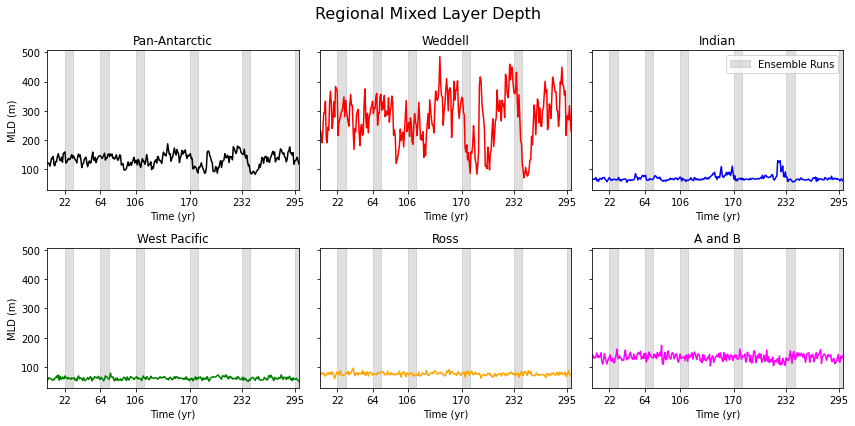

In [145]:
fig,ax = ctrl_grid_plot('mld', timescale='annual')

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/NPP/npp_ts_so_annual_mean.nc


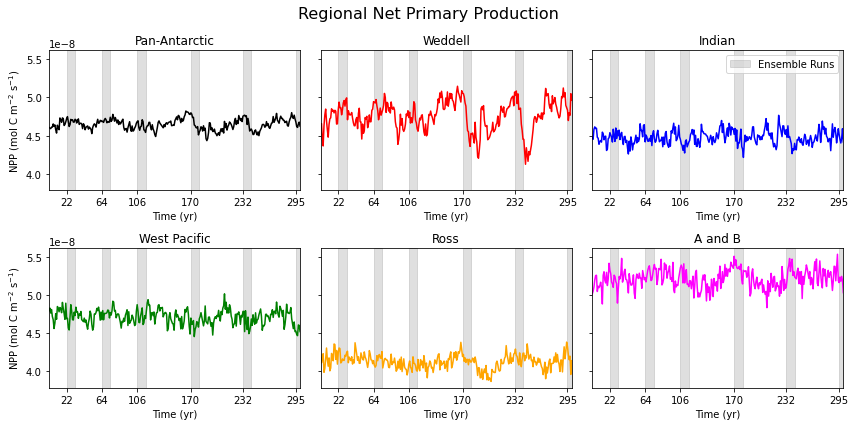

In [137]:
fig,ax = ctrl_grid_plot('npp', timescale='annual')

opened - /home/bbuchovecky/storage/so_predict_derived/CTRL/SFC_BIOMASS/sfc_biomass_ts_so_annual_mean.nc


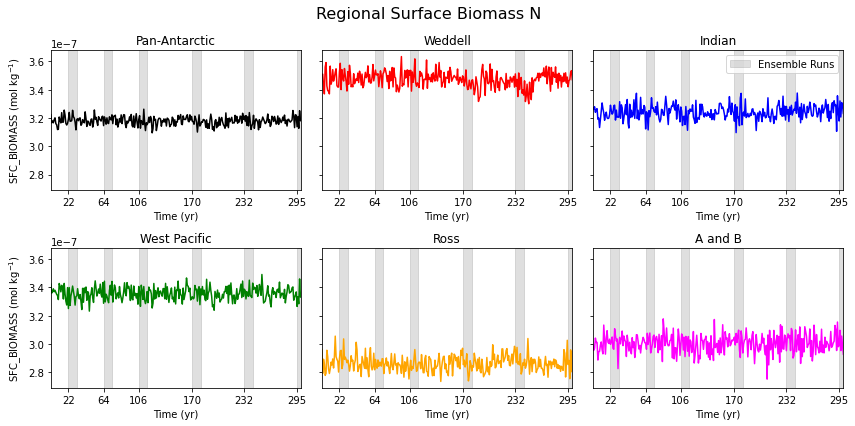

In [139]:
fig,ax = ctrl_grid_plot('sfc_biomass', timescale='annual')